In [12]:
import os
import random

import librosa
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForXVector, AutoFeatureExtractor
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [2]:
dataset_name = 'VoiceDatasetWav2Vec'
model_name = 'facebook/wav2vec2-base-960h'
num_workers = 8
batch_size = 24
learning_rate =  0.00003
warmup_steps_rate =  10
seed_number = 42

max_input_length = 4.0
log_interval = 100

data_path = '/workspace/ssd/AI_hub/speech_recognition/dataset/2.Validation/source_data/'

wandb={'project_name': 'wav2vec_contrastive_learning','run_name': 'wav2vecXvectorModel'}

save_path = f"./finetuned_model/{wandb['run_name']}_{model_name.split('/')[-1]}/best_model.pth"
save_path

'./finetuned_model/wav2vecXvectorModel_wav2vec2-base-960h/best_model.pth'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = Wav2Vec2ForXVector.from_pretrained(model_name)
model.load_state_dict(torch.load(save_path))
model.to(device)

Some weights of Wav2Vec2ForXVector were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForXVector(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (enco

In [5]:
class VoiceDatasetWav2Vec(Dataset):
    def __init__(self, data_path, max_length, model_name):
        self.data_path = data_path
        self.max_length = max_length
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.data = []
    
        for root, dirs, files in os.walk(self.data_path):
            for file in files:
                if file.endswith(".wav"):
                    self.data.append(os.path.join(root, file))
                    
        self.speaker_datas = {}
        for file in self.data:
            speaker_dir = os.path.dirname(file)
            # speaker_dir = speaker_dir.split('/')[-1]
            if speaker_dir not in self.speaker_datas:
                self.speaker_datas[speaker_dir] = []
            self.speaker_datas[speaker_dir].append(file)
        

    def load_audio(self, file_path):
        audio, sampling_rate = librosa.load(file_path, sr=16000)
        inputs = self.feature_extractor(audio, sampling_rate=sampling_rate, max_length=int(self.max_length * sampling_rate), truncation=True, padding="max_length", return_tensors="pt")
        return inputs.input_values.squeeze(0)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        anchor_data = self.data[idx]
        anchor_audio = self.load_audio(anchor_data)
        
        speaker_dir = os.path.dirname(anchor_data)
        speaker_datas = sorted(self.speaker_datas[speaker_dir])
        
        anchor_idx = speaker_datas.index(anchor_data)
        positive_idx = (anchor_idx + 1) % len(speaker_datas)
        positive_data = speaker_datas[positive_idx]
        positive_audio = self.load_audio(positive_data)
        
        negative_datas_dirs = [d for d in self.speaker_datas.keys() if d != speaker_dir]
        negative_speaker_dir = random.choice(negative_datas_dirs)
        negative_data = random.choice(self.speaker_datas[negative_speaker_dir])
        negative_audio = self.load_audio(negative_data)

        return anchor_audio, positive_audio, negative_audio
    

In [6]:
valid_dataset = VoiceDatasetWav2Vec(data_path, 4.0, model_name)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [7]:
def calculate_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1, embedding2).cpu().numpy()

In [8]:
model.eval()
similarities = []
labels = []

In [ ]:
valid_progress_bar = tqdm(valid_dataloader)
for idx, batch in enumerate(valid_progress_bar):
    anchor, positive, negative = batch
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    with torch.no_grad():
        anchor_embeddings = model(anchor).embeddings
        positive_embeddings = model(positive).embeddings
        negative_embeddings = model(negative).embeddings

    pos_similirarity = calculate_similarity(anchor_embeddings, positive_embeddings)
    neg_similirarity = calculate_similarity(anchor_embeddings, negative_embeddings)

    similarities.extend(pos_similirarity)
    similarities.extend(neg_similirarity)
    labels.extend([1] * len(pos_similirarity))
    labels.extend([0] * len(neg_similirarity))

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# Calculate F1 score at the optimal threshold
binary_predictions = (similarities > best_threshold).astype(int)
f1 = f1_score(labels, binary_predictions)

print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

  0%|          | 0/30598 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
 53%|█████▎    | 16283/30598 [38:22<33:38,  7.09it/s] 

In [10]:
print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

ROC AUC: 0.9973, Best Threshold: 0.3998, F1 Score: 0.9872


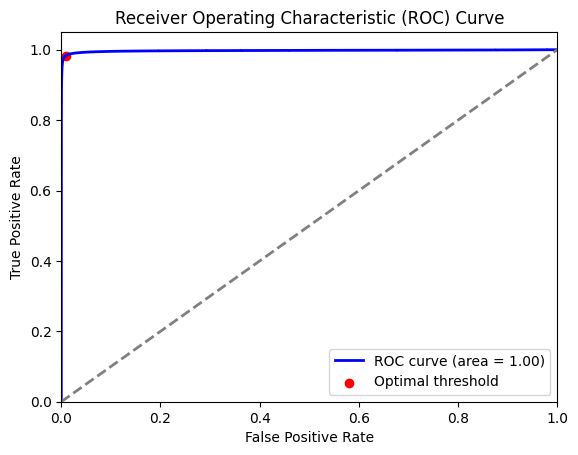

In [13]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()